# Постановка проблемы
По некоторым оценкам около 90% современных промышленных контроллеров относятся к ПИД-регуляторам из-за их простоты, низкой стоимости и надежности. Однако ПИД-регуляторы обладают рядом проблем, о которых нужно знать и иметь представление как их решать. Напомним формулу управляющего воздействия:

$$u\left(t\right)=k_pe\left(t\right)+\;k_i\int_0^te(\tau)\operatorname d\tau+k_d\dot e(t)$$

В этой работе рассматривается **проблема насыщения**.

Интегральная составляющая продолжает действовать, если исполнительный механизм не в состоянии обеспечить слишком большое управляющее воздействие. Это может произойти, например, если мощности нагревательного элемента не хватает для выхода на заданную температуру или размер вентиля недостаточен, чтобы обеспечить необходимый поток. В таких случаях говорят о насыщении исполнительного механизма, о достижении его предельного значения - максимального или минимального выходного параметра.

Когда параметр процесса перестает расти из-за насыщения, регулятор продолжает регистрировать отклонение параметров процесса от требуемых. Интеграл ошибки управления продолжает расти, и интегральная составляющая продолжает увеличивать требуемое управляющее воздействие. Тем не менее, исполнительный механизм уже работает на максимуме, так что траектория системы не выходит на требуемый режим.

Если требуемый режим изменится или исчезнет влияние неучтенных воздействий (например шумы), то ПИД-регулятор не сможет сразу отреагировать на это. Все дело в слишком большой величине интеграла ошибки, который накопился за время работы исполнительного механизма в предельном режиме. Значение интеграла надолго останется очень большим, вне зависимости от текущей величины отклонения. Воздействие интегральной составляющей будет долго оставаться очень большим, так что исполнительный механизм не выйдет из предельного режима.

Существует несколько решений данной проблемы. Ниже рассматриваются два из них, дающих одинаковые результаты.

# Реализация системы и регулятора

In [4]:
# Импортируем нужные библиотеки
import numpy as np
import scipy.integrate as sci
import matplotlib.pyplot as plt

In [5]:
# Класс ПИД-регулятора
class PID_controller():
    def __init__(self, kp = 0, ki = 0, kd = 0, mode = "original"):
    
        self.kp = kp
        self.ki = ki
        self.kd = kd
        self.dt = 0.01
    
        self.integral = 0
        self.e_prev = None # ошибка на предыдущем шаге
        self.e_prev_prev = None # ошибка на предпредыдущем шаге
        self.control_output = 0 # вычисляемое упарвление
        self.control_output_prev = 0 # управление на предыдущем шаге

        self.u_max_abs = 5. / 1. # Максимальное возможное управление, которое мы можем мовершить
        self.mode = mode
        # mode отражает в каком режиме будет работать ПИД - регулятор
        # В этой программе их три:
        # 1. original - без изменений, стандартный ПИД - регулятор, подверженный проблеме насыщения
        # 2. simple_algorithm - простейший алгоритм, решающий проблему насыщения. Его суть в следующем:
        # если рассчитанное стандартным ПИД - регулятором воздействие больше максимально доступного нам,
        # то мы НЕ увеличиваем интеграл, отвечающий за накопление ошибки. 
        # Таким образом интеграл не накапливается.
        # 3. incremental_algorithm - алгоритм, взятый из статьи 
        # https://folk.ntnu.no/skoge/prost/proceedings/PID-2018/0061.PDF, страницы 2-3
        # Алгоритм состоит в вычислении приращения управления ∆u(k) на каждом шаге и
        # добавлении к предыдущему управляющему сигналу u(k−1) только той величины, 
        # которая не приводит к насыщению исполнительного механизма.
        
    def set_kp(kp):    
        self.kp = kp
        
    def set_ki(ki):    
        self.ki = ki
    
    def set_kd(kd):    
        self.kd = kd        
        
    # реализация трех режимов
    def update(self, state, reference):
        error = reference - state
        
        if self.e_prev == None:
            e_dot = 0
        else:
            e_dot = (error - self.e_prev) / self.dt

        self.integral += error * self.dt
        
        self.control_output = self.kp * error + self.kd * e_dot + self.ki * self.integral

        if self.mode == "simple_algorithm":
            if abs(self.control_output) >= self.u_max_abs:
                self.integral -= error * self.dt

        # Отмечу, что я взял alpha = 0 для простоты
        if self.mode == "incremental_algorithm":
            if self.e_prev == None:
                b1 = 0
            else:
                b1 = (-self.kp*self.dt - 2*self.kd)*self.e_prev/self.dt
            if self.e_prev_prev == None:
                b2 = 0
            else:
                b2 = self.kd*self.e_prev_prev/self.dt
            b0 = (self.kp*self.dt + self.ki*self.dt*self.dt + self.kd)*error/self.dt
            
            self.control_output = b0 + b1 + b2 + self.control_output_prev

            if self.control_output - self.u_max_abs > 0.001:
                self.control_output = self.u_max_abs
                
            self.e_prev_prev = self.e_prev
            self.control_output_prev = self.control_output

        self.e_prev = error

        return self.control_output
        
    def get_ctrl(self, state, reference): 
        out = self.update(state, reference)
        return out 

In [6]:
# класс контролируемой системы
class controlSystem(object):
    def __init__(self, rhs, param):
        self.t0 = 0.
        self.tf = 80.
        self.ctrl_loop = 0.01 # шаг по времени
        self.x0 = [0., 0.] # начальные условие 
        self.param = param # параметры нашей системы, для разных систем м. б. разные наборы параметров
        self.rhs_fun = rhs # правая часть ДУ, описывающего нашу систему
        self.result = np.hstack((self.t0, self.x0))
        self.u_array = []

    def ode_rhs(self, t, x, p, pid = None):
        return self.rhs_fun(t, x, p, pid)
        
    # Здесь решаем диффур с помощью scipy
    def simulate(self, pid = None):   
        if pid == None:
            t_sol = np.arange(self.t0, self.tf, self.ctrl_loop)
            sol = sci.solve_ivp(lambda t, x: self.ode_rhs(t, x, self.param, pid), \
                                (self.t0, self.tf), self.x0, t_eval = t_sol, rtol=1e-10, atol=1e-10)
            self.result = np.vstack((sol.t, sol.y)).T
        else:
            t_curr = self.t0
            x_curr = self.x0
            self.u_array.append(pid.get_ctrl(x_curr[0], self.param.ctrl_req))
            while t_curr < self.tf:
                sol = sci.solve_ivp(lambda t, x: self.ode_rhs(t, x, self.param, pid), \
                                    (t_curr, t_curr + self.ctrl_loop), x_curr, rtol=1e-6, atol=1e-6)
                self.result = np.vstack((self.result, np.hstack((sol.t[-1], sol.y[:,-1]))))
                t_curr = sol.t[-1]
                x_curr = sol.y[:,-1]

                # Собираем данные об управлении на каждом шаге, так как хотим строить график u(t)
                u = pid.get_ctrl(x_curr[0], self.param.ctrl_req)
                u_max_abs = 5. / self.param.m
                if u > param.u_max_abs: u = param.u_max_abs
                if u < - param.u_max_abs: u = - param.u_max_abs
                self.u_array.append(u)

    def plotXV(self):
        x = self.result[:, 1];
        v = self.result[:, 2];
        lim = 1.5 * np.max([np.max(np.abs(x)), np.max(np.abs(v))])

        ax = plt.subplot(111)
        ax.plot(x, v)
        ax.grid(True)
        ax.set_title('Phase Plane')
        ax.set_ylabel(r'v')
        ax.set_xlabel(r'x')
        ax.set_xlim(-lim, lim)
        ax.set_xlim(-lim, lim)
        #ax.set_aspect('equal')

        plt.show()
        
    def plotTX(self):
        t = self.result[:, 0];
        x = self.result[:, 1];
        lim = 1.5 * np.max(np.abs(x))
        
        ax = plt.subplot(111)
        ax.plot(t, x)
        ax.plot(t, [self.param.ctrl_req for _ in range(len(t))],
        linestyle = '--',
        linewidth = 1,
        color = 'darkmagenta')
        ax.grid(True)
        ax.set_title('Position vs Time')
        ax.set_ylabel(r'x')
        ax.set_xlabel(r't')
        ax.set_ylim(-lim, lim)

        plt.show()

    def plotTU(self):
        t = self.result[:, 0];
        lim = 1.5 * np.max(np.abs(self.u_array))

        ax = plt.subplot(111)
        ax.plot(t[1:], self.u_array[1:])
        ax.grid(True)
        ax.set_title('Control signal vs Time')
        ax.set_ylabel(r'u')
        ax.set_xlabel(r't')
        ax.set_ylim(-lim, lim)

        plt.show()           

# Постановка тестовой задачи

Имеем брусок массы m с трением и на пружинке. При t = 0 брусок покоится в начале координат на горизонтальной поверхности. Уравнение нашей системы: 
$$m\ddot x\;+\;\beta\dot x+\;kx\;=\;u\;+\;F(t),\;где $$
u - управление

F(t) - неучтённые нами внешние силы. Например, ветер или неожидаемый наклон стола, приводящий к появлению силы тяжести.

Задача: привести брусок в состояние покоя в точке x = 1.

При этом модуль управляющего воздействия ограничен.

# Реализация тестовой задачи

In [7]:
class Parameters(object):
    pass

param = Parameters()
param.m = 1. # масса бруска
param.b = 1  # коэффициент трения
param.k = 1. # коэффициент жесткости пружинки
param.ctrl_req = 1 # требование, куда нужно привести
param.u_max_abs = 5. / param.m # максимально возможное управление, соответствует 5 Н

# Неучтенная внешняя сила
# Действует первые 10 секунд и имеет модуль 25 Н
def F_noise(t):
  t_begin = 0
  t_end = 10
  F_abs = 25
  if t >= t_begin and t <= t_end:
      return -F_abs
  else:
      return 0

#  Правая часть ДУ, описывающего нашу систему
def rhs(t, x, p, pid = None):
    if pid == None:
        u = 0
    else:
        u = pid.get_ctrl(x[0], p.ctrl_req)
    
    # Если управление больше допустимого, то "обрезаем" его:
    if u > p.u_max_abs: u = p.u_max_abs
    if u < - p.u_max_abs: u = - p.u_max_abs

    dxdt = np.zeros(2)
    dxdt[0] = x[1]
    dxdt[1] = -p.k * x[0] / p.m - p.b * x[1] / p.m + u + F_noise(t) / p.m
    
    return dxdt

# Результаты тестовой задачи

Сначала рассматриваем обычный ПИД - регулятор.

Как видим, ошибка в интеграле, накопленная за время действия внешней силы, приводит к тому, что даже при отрицательной ошибке (после 12 секунды) управление остается неизменным и излишним до 60 секуды.

Координата устанавливается через 55 секунд (в 65 секунд) после прекращений действия неучтенной силы.

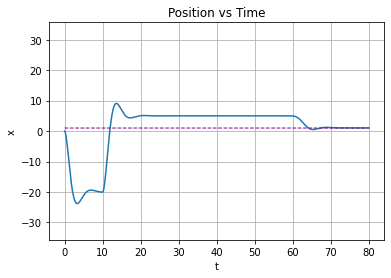

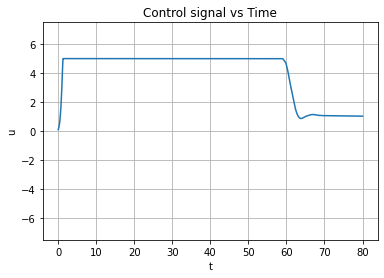

In [8]:
pid_original = PID_controller(0.1, 0.01, 0.1)
cs = controlSystem(rhs, param)
cs.simulate(pid_original)
cs.plotTX()
cs.plotTU()
# Штриховая линия - куда хотим попасть (r(t) = 1)

Теперь рассмотрим ПИД - регулятор, который не увеличивает интеграл при управлении, равном максимальному.

Здесь наблюдаем иную картину: после прекращения внешнего воздействия управление сразу начинает изменяться, для достижения r(t).

В результате координата устанавливается через 15 секунд (в 25 секунд) после прекращения воздействия. Разница с предыдущей схемой в 3 раза.

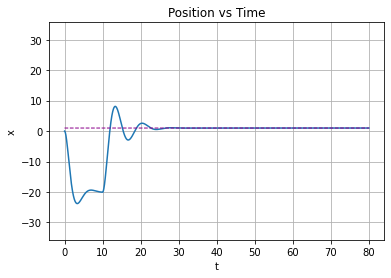

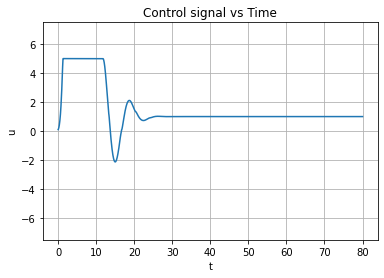

In [9]:
pid_improved1 = PID_controller(0.1, 0.01, 0.1, "simple_algorithm")
cs = controlSystem(rhs, param)
cs.simulate(pid_improved1)
cs.plotTX()
cs.plotTU()

Последняя схема, использующая инкрементирующий алгоритм. Принципиально графики и время установления такие же, как и у предыдущей схемы. 

Насколько я понимаю, плюс этой схемы в том, что мы используем не всё управление во время действия неучтенной силы, а получаем при этом такие же результаты.

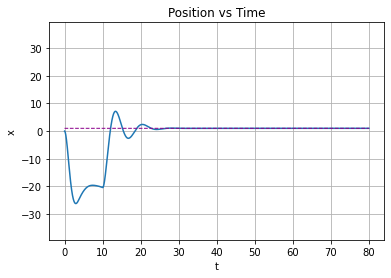

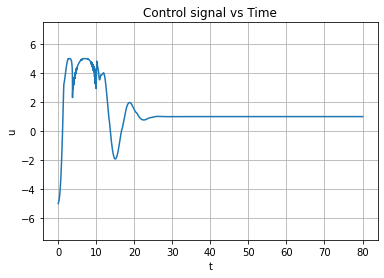

In [10]:
pid_improved2 = PID_controller(0.1, 0.01, 0.1, "incremental_algorithm")
cs = controlSystem(rhs, param)
cs.simulate(pid_improved2)
cs.plotTX()
cs.plotTU()